# 语义分割（semantic-segmentation）和数据集

语义分割
- 语义分割将图片中的**每个像素**分类到对应的类别
- 语义分割与一般的分割（如聚类）不同的是，语义分割是有监督的学习

应用：
- 背景虚化
- 路面分割

vs：
- 语义分割只关心像素属于哪一类
- **图像分割**：将图像划分为若干组成区域
  - 通常利用图像中像素之间的相关性
  - 在训练时，不需要有关图像像素的标签信息
  - 在预测时，无法保证分割出的区域具有希望得到的语义
- **实例分割**：研究如何识别图像中各个目标实例的像素级区域（具体某个类的实例都会区分开）
  - 不仅需要区分语义，还要区分不同的目标实例
- 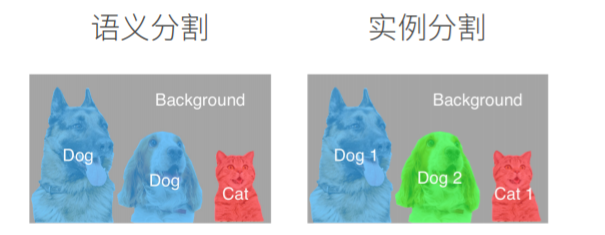

# 代码

## Pascal VOC2012 语义分割数据集

In [1]:
!pip install d2l

In [2]:
import torch
import torchvision

from d2l import torch as d2l

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
d2l.DATA_HUB['voc2012'] = [
    d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
    '4e443f8a2eca6b1dac8a6c57641b67dd40621a49'
]

DATA_HUB = d2l.DATA_HUB

import hashlib
import os
import requests
import tarfile
import zipfile

data_dir_drive = '/content/drive/My Drive/ColabData/data'

def download(name, cache_dir=data_dir_drive)):
  assert name in DATA_HUB, f"{name}不存在于{DATA_HUB}中。"
  url, sha1_hash = DATA_HUB[name]
  os.makedirs(cache_dir, exist_ok=True)
  fname = os.path.join(cache_dir, url.split('/')[-1])
  if os.path.exists(fname):
    sha1 = hashlib.sha1()  # 创建一个SHA-1哈希对象
    with open(fname, 'rb') as f:
      while True:
        data = f.read(1048576)  # 以每次 1 MB 的块大小读取
        if not data:  # data为空，文件读取完毕
          break
        sha1.update(data)
    if sha1.hexdigest() == sha1_hash:
      return fname # 文件已经存在且完整
  print(f'正在从{url}下载{fname}...')
  r = requests.get(url, stream=True, verify=True)
  with open(fname, 'wb') as f:
    f.write(r.content)
  return fname

def download_extract(name, folder=None):
  fname = download(name)
  base_dir = os.path.dirname(fname)  # 提取文件路径中所在的目录（去掉文件名部分）
  data_dir, ext = os.path.splitext(fname)  # 将文件名拆为文件路径和文件扩展名
  if ext == '.zip':
    with zipfile.ZipFile(fname, 'r') as z:
      z.extractall(base_dir)  # 解压`zip`文件中所有内容，并放在`base_dir`路径下
  elif ext in ('.tar', '.gz'):
    with tarfile.open(fname, 'r') as t:
      t.extractall(base_dir)
  else:
    raise ValueError('只有zip/tar文件可以被解压缩。')
  return os.path.join(base_dir, folder) if folder else data_dir

In [4]:
voc_dir = download_extract('voc2012', 'VOCdevkit/VOC2012')
voc_dir

正在从http://d2l-data.s3-accelerate.amazonaws.com/VOCtrainval_11-May-2012.tar下载/content/drive/My Drive/ColabData/data/VOCtrainval_11-May-2012.tar...


'/content/drive/My Drive/ColabData/data/VOCdevkit/VOC2012'

**将所有输入的图像和标签读入内存**
- 读取所有VOC图像并标注

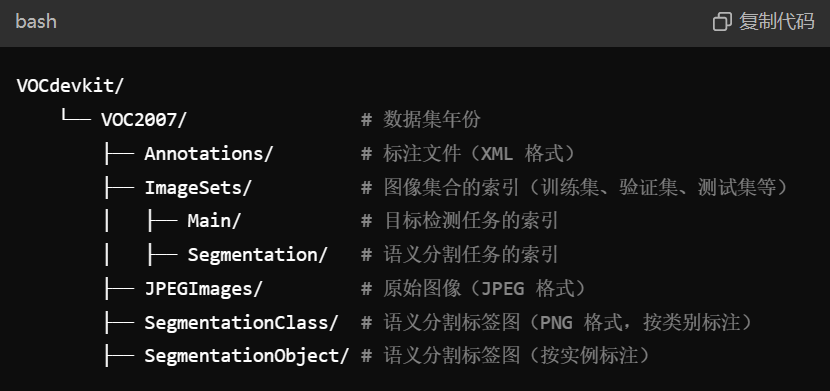

- `torchvision.io.image.ImageReadMode.RGB`：
  - 一种图像读取模式，指定在读取图像时将其转换为**RGB格式**
- VOC的数据集格式
  - `ImageSets/Segmentation`路径包含用于训练和测试样本的文本文件
  - `JPEGImages`存储每个示例的输入图像
  - `SegmentationClass`存储每个示例的标签
- `labels`：`jpg`会*压缩、模糊边缘*，选择没有压缩的**`png`**

- `f.read()`读取整个文件的内容
- `.split(sep=None)`按照空白字符（包括空格，换行符`\n`，制表符`\t`等）分割字符串

In [3]:
import os
# voc_dir = '/content/drive/My Drive/ColabData/data/VOCdevkit/VOC2012'

def read_voc_images(voc_dir, is_train=True):
  # 得到训练/验证 文件名
  txt_fname = os.path.join(
    voc_dir, 'ImageSets', 'Segmentation',
    'train.txt' if is_train else 'val.txt'
  )
  mode = torchvision.io.image.ImageReadMode.RGB
  with open(txt_fname, 'r') as f:
    images = f.read().split()
  # 标注
  features, labels = [], []
  for i, fname in enumerate(images):
    features.append(torchvision.io.read_image(
      os.path.join(voc_dir, 'JPEGImages', f'{fname}.jpg')
    ))
    labels.append(
      torchvision.io.read_image(
        os.path.join(voc_dir, 'SegmentationClass', f'{fname}.png'),
        mode
      )
    )
  return features, labels

train_features, train_labels = read_voc_images(voc_dir, is_train=True)

**绘制前5个输入图像及其标签**

- `torchvision.io.read_image`返回一个张量：`[channels, height, width]`
  - **'channnel-first'**格式
- `imshow`的输入格式要求：`[height, width, channels]`
  - **'channel-last'**格式

- **`+`**对于列表而言（列表形式的张量集合），是**拼接**作用，返回一个新的列表

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

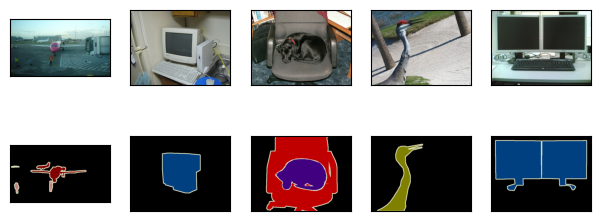

In [4]:
n = 5
imgs = train_features[:n] + train_labels[:n]
imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs, 2, n)

**列举RGB颜色值和类名**，可以方便查找标签中每个像素的类索引

In [5]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

**查找标签中每个像素的类索引**
- 标签图通常以颜色编码（RGB）表示，不直接包含类别索引

`voc_colormap2lable`：构建从上述RGB颜色值到类别索引的映射

`voc_label_indices`：将RGB值(语义分割标签图中的）映射在Pascal VOC2012数据集中的类别索引

- 不要用简单的Python去运行，会很慢！
- `torch.zeros(256 ** 3, dtype=torch.long)`：RGB的每个通道的取值范围都是`[0, 255]`
- `voc_label_indices`的输出是一个二维数组`[H, W]`，每个值对应像素的类别索引
  - `idx`是一个`[H, W]`形状的——输出形状和`idx`一致

In [6]:
def voc_colormap2label():
  colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
  for i, colormap in enumerate(VOC_COLORMAP):
    colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
  return colormap2label

def voc_label_indices(colormap, colormap2label):
  colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
  idx = (
    (colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
    + colormap[:, :, 2]
  )
  return colormap2label[idx]

`train_labels`对应的就是`colormap`

In [8]:
y = voc_label_indices(train_labels[0], voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[:1]

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]),
 'aeroplane')

### 预处理数据

在前面卷积中，通过再**缩放**图像使其复合模型的输入形状，但是不适合语义分割
- 需要将预测的像素类别重新映射回原始尺寸的输入图像

将图像**剪裁**
  - **使用图像增广中的随机裁剪，裁剪输入图像和标签相同区域**


- `torchvision.transforms.RandomCrop.get_params(img, output_size)`：用于为随机裁剪操作生成参数（随机剪裁的位置和尺寸）
  - 返回一个四元组`(i, j, h, w)`随机剪裁的左上角坐标
- `torchvision.transforms.functional.crop(img, top, left, height, width)`：用于按照指定的坐标和尺寸从输入图像中裁剪出一块区域
  - `torchvision.transforms.RandomCrop`自动剪裁，*无法指定*自定义的裁剪参数

- `imshow`的输入支持`numpy`数组，但不支持`tensor`张量

In [7]:
def voc_rand_crop(feature, label, height, width):
  rect = torchvision.transforms.RandomCrop.get_params(feature, (height, width))
  feature = torchvision.transforms.functional.crop(feature, *rect)
  label = torchvision.transforms.functional.crop(label, *rect)
  return feature, label

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

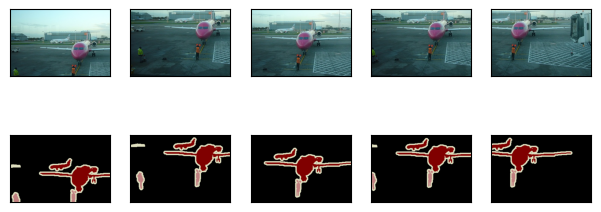

In [10]:
imgs = []  # list形式！
for _ in range(n):
  imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)

imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs[::2] + imgs[1::2], 2, n)

### 自定义语义分割数据集类

通过继承高级API提供的`Dataset`类，自定义一个语义分割数据集类`VOCSegDataset`
  - **`__getitem__`函数**：任意访问数据集中索引为`idx`的输入图像及其每个像素的类别索引
  - `filter`函数：移除图像的尺寸小于随机剪裁指定的输出尺寸
  - `normalize_image`函数：对输入图像的RGB三个通道的值分别做标准化


`__init__`:初始化方法，通常用于定义类实例的属性和初始化必要的状态
- **初始化必需**的逻辑：与对象的创建直接相关，且是对象使用前必须完成的，**不需要单独被调用**
- 不需要重用（反复调用）
- 没有通用性，不具备单独使用的意义

**自定义`Dataset`类**
- **核心要求**
  - **`__getitem__(self, idx)`和`__len__(self)`是必需的方法！**
- 当**数据是一次性加载到内存**时，将数据存储为**类属性**，如`self.features`，`self.labels`
- 当**数据是懒加载**的，数据很大，无法一次性加载进内存，可以在**`__getitem__`中按需加载**

In [8]:
class VOCSegDataset(torch.utils.data.Dataset):
  def __init__(self, is_train, crop_size, voc_dir):
    self.transform = torchvision.transforms.Normalize(
      mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    )
    self.crop_size = crop_size
    features, labels = read_voc_images(voc_dir, is_train=is_train)

    self.features = [
      self.normalize_images(feature) for feature in self.filter(features)
    ]
    self.labels = self.filter(labels)
    self.colormap2label = voc_colormap2label()
    print('read' + str(len(self.features)) + 'examples')


  def normalize_images(self, img):
    return self.transform(img.float() / 255)

  def filter(self, imgs):
    return [img for img in imgs if (
      img.shape[1] >= self.crop_size[0] and
      img.shape[2] >= self.crop_size[1]
    )]

  def __getitem__(self, idx):
    # 剪裁
    features, labels = voc_rand_crop(self.features[idx],
      self.labels[idx], *self.crop_size
    )
    # 换标号
    return (features, voc_label_indices(labels, self.colormap2label))

  def __len__(self):
    return len(self.features)

### 读取数据集

In [9]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read1114examples
read1078examples


标签得到的是一个三维数组

In [10]:
batch_size = 64
train_iter = torch.utils.data.DataLoader(
  voc_train, batch_size, shuffle=True, drop_last=True
)
for X, Y in train_iter:
  print(X.shape)
  print(Y.shape)
  break

torch.Size([64, 3, 320, 480])
torch.Size([64, 320, 480])


### 整合所有组件

In [11]:
def load_data_voc(batch_size, crop_size):
  voc_dir = download_extract('voc2012', os.path.join('VOCdevkit', 'VOC2012'))
  num_workers = 2
  train_iter = torch.utils.data.DataLoader(
    VOCSegDataset(True, crop_size, voc_dir),
    batch_size, shuffle=True, drop_last=True, num_workers=num_workers
  )
  test_iter = torch.utils.data.DataLoader(
    VOCSegDataset(False, crop_size, voc_dir),
    batch_size, shuffle=False, drop_last=True, num_workers=num_workers
  )
  return train_iter, test_iter